# Librerias

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

# Lectura de datos

In [2]:
# Cargar el archivo .nc utilizando xarray
data_boyaca = xr.open_dataset('../data/data_Boyaca.nc')

# Leer el shapefile con los municipios de Boyacá
shape_boyaca_municipios = gpd.read_file('../shapes/shape_boyaca_municipios.shp')

# Seleccionar la variable de precipitación
precipitation = data_boyaca['precip']

# Mapa de calor del promedio de la precipitación mensual para cada año

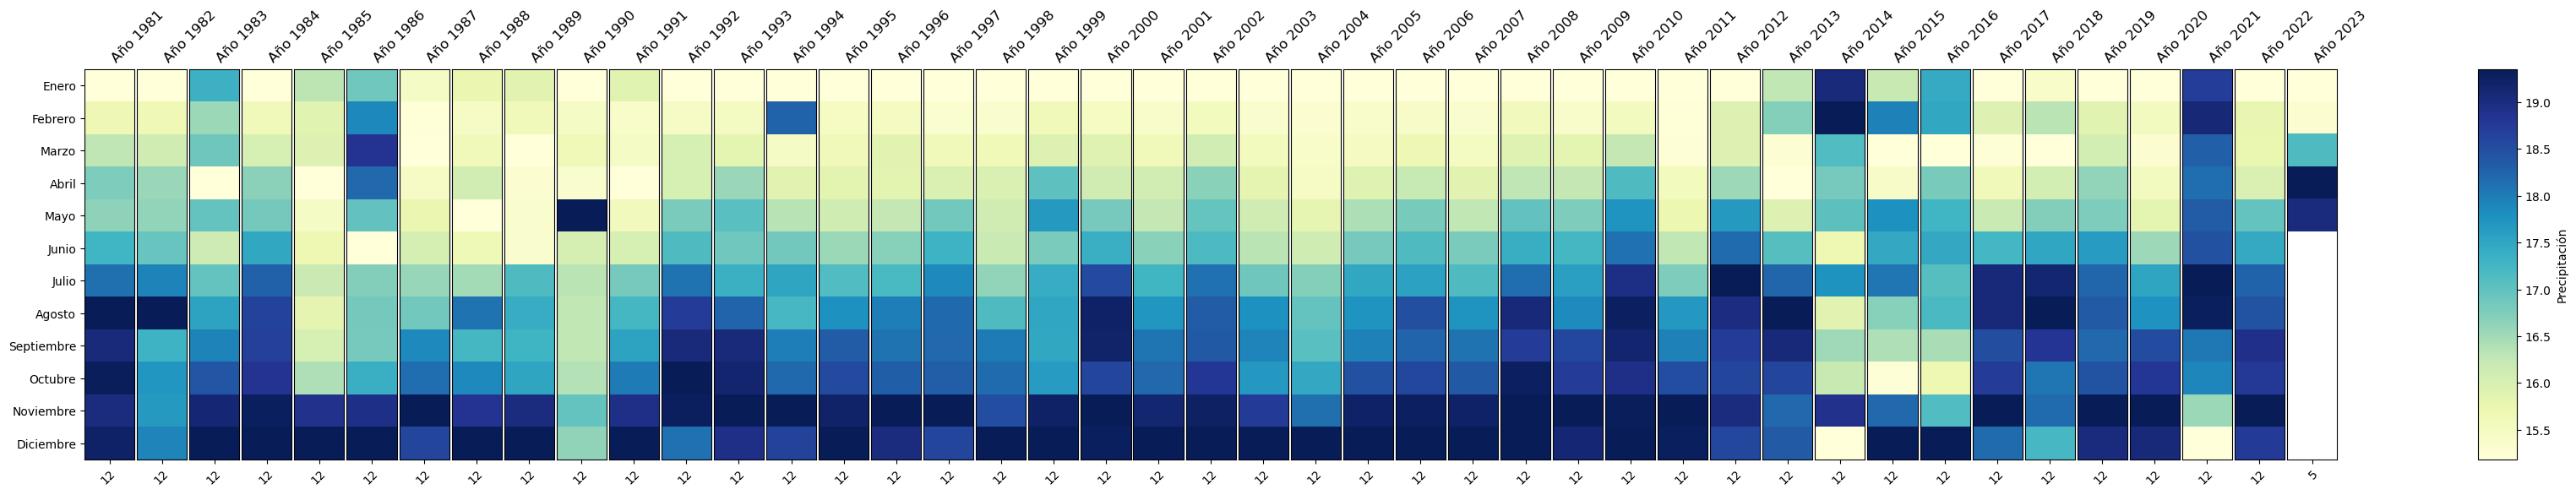

In [3]:
# Convertir el índice de tiempo a una serie de pandas
time_series = pd.Series(precipitation.time.values)

# Obtener los años únicos
años_disponibles = time_series.dt.year.unique()

# Calcular el número de mapas de calor
num_mapas = len(años_disponibles)

# Ajustar el espacio entre las subtramas y el tamaño de la figura
fig, axs = plt.subplots(1, num_mapas, figsize=(num_mapas, 6), sharey=True)

plt.subplots_adjust(wspace=0.05)

# Iterar sobre cada año y generar el mapa de calor en el gráfico correspondiente
for i, año in enumerate(años_disponibles):
    # Seleccionar los datos de precipitación para el año actual
    precipitacion_anual = precipitation.sel(time=str(año))
    
    # Calcular la precipitación mensual promedio
    precipitacion_mensual = precipitacion_anual.groupby('time.month').mean(dim='time')
    
    # Tratamiento de datos atípicos por mes utilizando el rango intercuartil (IQR)
    Q1 = precipitacion_mensual.quantile(0.25, dim='month')
    Q3 = precipitacion_mensual.quantile(0.75, dim='month')
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Reemplazar los valores atípicos por el promedio del mes correspondiente
    precipitacion_mensual = precipitacion_mensual.where((precipitacion_mensual >= lower_bound) & (precipitacion_mensual <= upper_bound), precipitacion_mensual.mean(dim='month'))
    
    # Crear un dataframe de Pandas a partir de los datos
    df = precipitacion_mensual.to_dataframe()

    # número de meses en el año
    num_meses = len(df.index.get_level_values(0).unique())
    
    # Obtener los últimos 12 meses de datos
    df = df.iloc[-num_meses:]
    
    # Reorganizar los datos en un formato adecuado para el mapa de calor
    df_heatmap = df.unstack(level=0)['precip']
    
    # Obtener el gráfico correspondiente
    ax = axs[i]
    
    # Crear el mapa de calor utilizando Matplotlib
    heatmap = ax.imshow(df_heatmap, cmap='YlGnBu', aspect='auto')
    
    # Personalizar el mapa de calor
    ax.set_xticks(np.arange(len(df_heatmap.columns)))
    ax.set_yticks(np.arange(12))
    
    # Establecer las etiquetas del eje y en el primer gráfico para siempre mostrar 12 meses
    if i == 0:
        month_labels = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
        ax.set_yticks(np.arange(len(month_labels)))  
        ax.set_yticklabels(month_labels)  
    else:
        ax.get_yaxis().set_visible(False)

    
    # Establecer las etiquetas del eje x
    ax.set_xticklabels(df_heatmap.columns, rotation=45, ha='right', rotation_mode='anchor')
    
    # Agregar un título con el año actual
    ax.set_title('Año {}'.format(año), rotation=45, ha='left')

    # Ajustar los límites del eje y para que las etiquetas del eje y se muestren completamente en el primer gráfico
    if i == 0:
        ax.set_ylim(len(month_labels)-0.5, -0.5)

# Agregar una única barra de color
cbar = fig.colorbar(heatmap, ax=axs, aspect=10)
cbar.set_label('Precipitación')


# Mostrar el gráfico
plt.show()


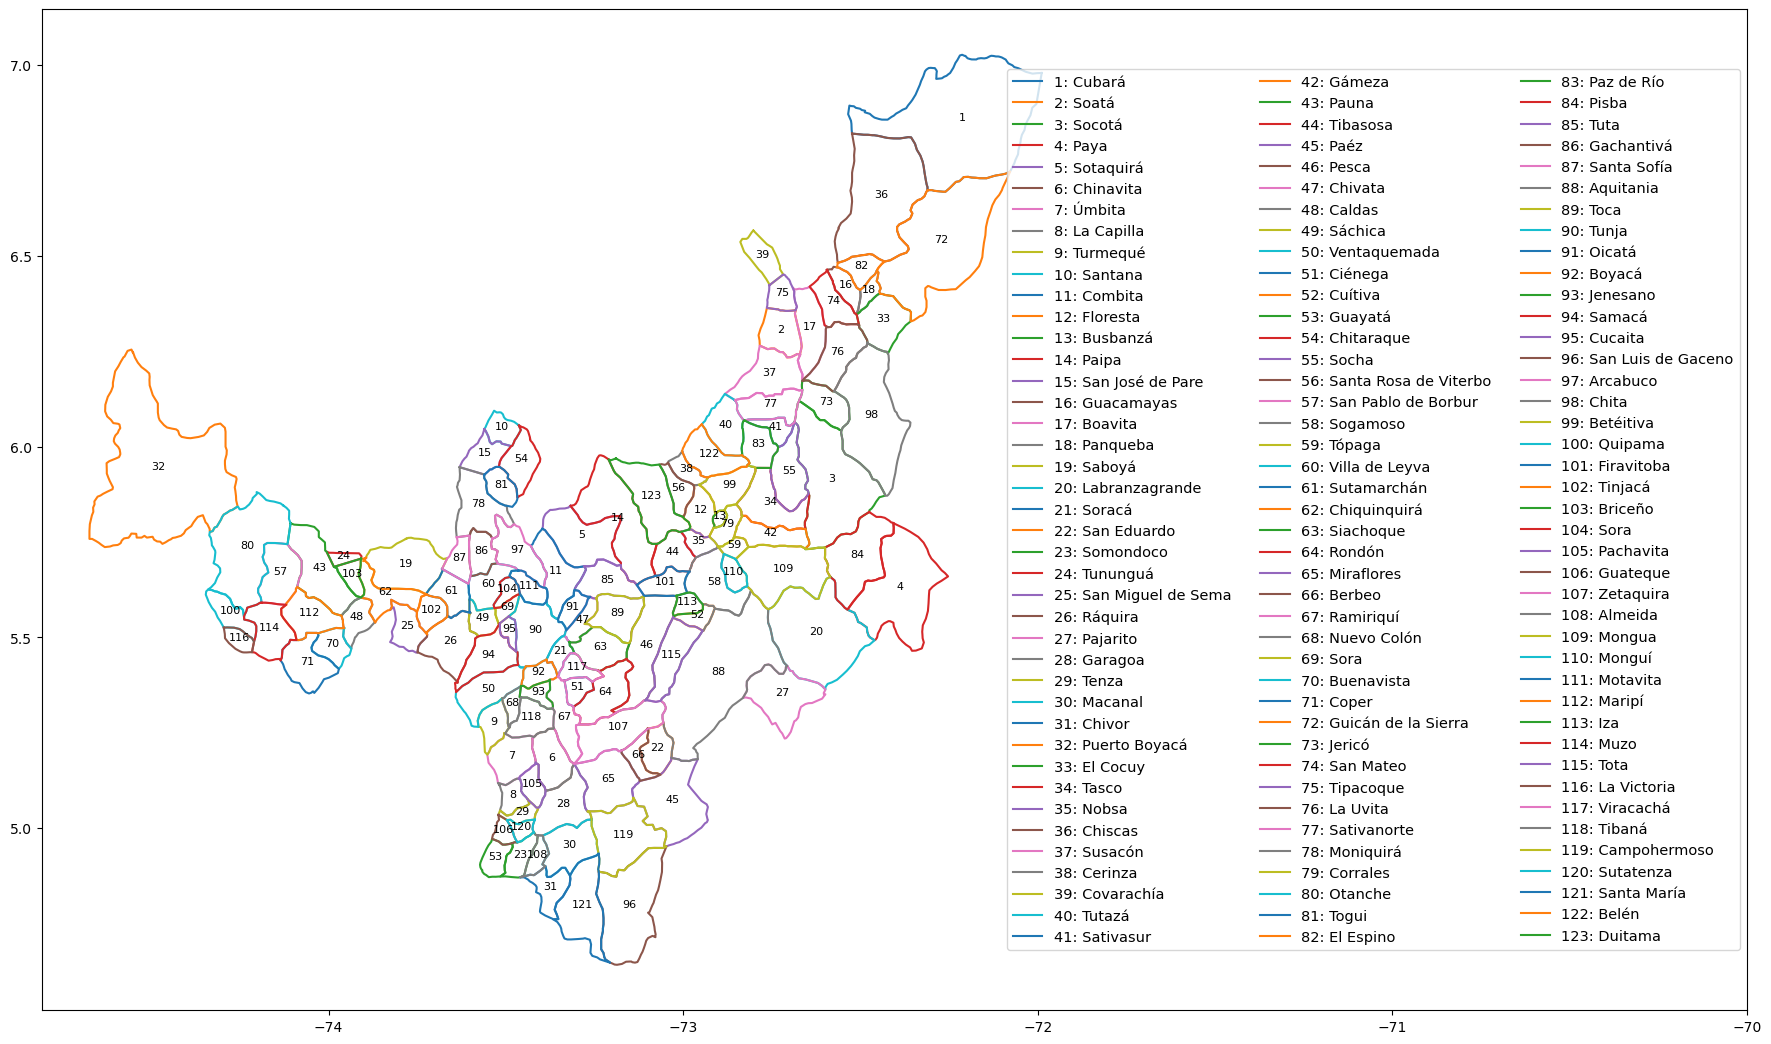

In [4]:
# Grafico con los poligonos ordenados
# Crear una figura y un eje
fig, ax = plt.subplots()
fig.set_size_inches(22, 13)

for i, polygon in enumerate(shape_boyaca_municipios.geometry):
    x, y = polygon.exterior.xy
    ax.plot(x, y)
    centroid = polygon.centroid
    ax.annotate(str(i+1), (centroid.x, centroid.y), textcoords="offset points", xytext=(0,0), ha='center', fontsize=8)

# Etiquetas de leyenda
etiquetas_leyenda = [f"{i+1}: {shape_boyaca_municipios.iloc[i]['municipio']}" for i in range(len(shape_boyaca_municipios))]

# Agregar la leyenda al gráfico
ax.legend(labels=etiquetas_leyenda, fontsize=10.5, ncol=3, loc='center right')
# Agrandar el eje x para que quepa la leyenda
ax.set_xlim(right=-70)

# Mostrar el gráfico
plt.show()


In [5]:
# Recortar los datos a los límites de Boyacá
pr_boyaca = precipitation.sel(latitude=slice(min_latitude, max_latitude), longitude=slice(min_longitude, max_longitude))

# Seleccionar un año específico 
year = 2013
pr_year = pr_boyaca.sel(time=str(year))

# Seleccionar el primer paso de tiempo
v = pr_year.isel(time=0).values

# Convertir a valores normales para el trazado
x = pr_year.longitude.values
y = pr_year.latitude.values
xx, yy = np.meshgrid(x, y)

# Plot
fig, ax = plt.subplots()
im = ax.pcolormesh(xx, yy, v, shading='auto', cmap='rainbow')
fig.colorbar(im, ax=ax)
shape_boyaca_municipios.plot(ax=ax, color='none', edgecolor='k')

plt.show()

# Filtrar los datos dentro de los polígonos de Boyacá
mask = shape_boyaca_municipios.geometry.unary_union.contains(gpd.points_from_xy(xx.ravel(), yy.ravel()))
v_filtered = np.where(mask.reshape(xx.shape), v, np.nan)

# Plot
fig, ax = plt.subplots()
im = ax.pcolormesh(xx, yy, v_filtered, shading='auto', cmap='rainbow')
fig.colorbar(im, ax=ax)
shape_boyaca_municipios.plot(ax=ax, color='none', edgecolor='k')

plt.show()


NameError: name 'min_latitude' is not defined

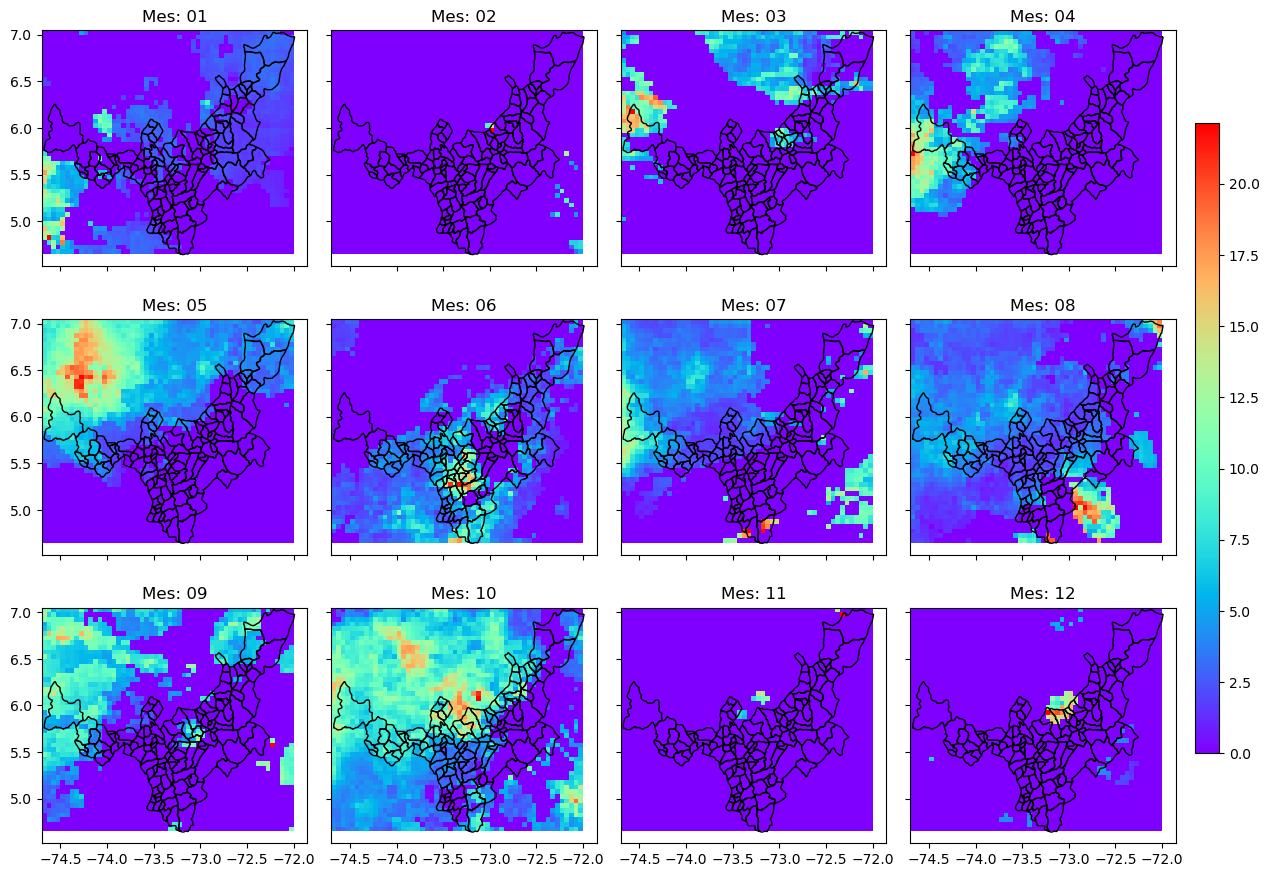

In [6]:
# Seleccionar un año específico 
year = 2022
pr_year = precipitation.sel(time=str(year))

# Crear la cuadrícula de subtramas
fig, axes = plt.subplots(3, 4, figsize=(12, 9), sharex=True, sharey=True)

# Iterar sobre los meses
for month, ax in zip(range(1, 13), axes.flat):
    # Seleccionar el mes específico
    pr_month = pr_year.sel(time=f'{year}-{month:02}')
    
    # Seleccionar el primer paso de tiempo
    v = pr_month.isel(time=0).values
    
    # Convertir a valores normales para el trazado
    x = pr_month.longitude.values
    y = pr_month.latitude.values
    xx, yy = np.meshgrid(x, y)
    
    # Plot del mapa de calor en la subtrama actual
    im = ax.pcolormesh(xx, yy, v, shading='auto', cmap='rainbow')
    shape_boyaca_municipios.plot(ax=ax, color='none', edgecolor='k')
    ax.set_title(f'Mes: {month:02}')

# Ajustar los espacios entre las subtramas
plt.tight_layout()

# Agregar una barra de color común para todos los mapas de calor
cax = fig.add_axes([1, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cax)

# Mostrar la figura
plt.show()


In [ ]:
import xarray as xr

# Ruta al archivo .nc filtrado
filtered_nc_path = "./data_Boyaca.nc"

# Leer el archivo .nc utilizando xarray
ds_filtered = xr.open_dataset(filtered_nc_path)

# cantidad de datos ds_filtered
print(ds_filtered.precip.count())

# Verificar los nombres de las variables disponibles
print(ds_filtered)



import geopandas as gpd

# Ruta al archivo .shp
ruta_archivo = './shapes/shape_boyaca.shp'

# Lee el archivo .shp
datos_shapefile = gpd.read_file(ruta_archivo)

# Muestra el formato
print('shapefile : ',datos_shapefile)





FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\BPS-EYDUARTE\\OneDrive\\Documentos\\PROYECTO\\Degree_Project\\notebooks\\data_Boyaca.nc'

* Datos nulos: Según el resultado, no hay valores nulos en la variable "precip". El recuento de valores nulos es 0, lo que indica que no hay datos faltantes en los puntos de tiempo, latitud y longitud considerados.

* Desviación estándar: La desviación estándar proporciona una medida de la variabilidad de los datos de precipitación en cada punto espacial. Los valores de desviación estándar varían según la latitud y longitud. A medida que te mueves de norte a sur y de oeste a este en el departamento de Boyacá, la desviación estándar tiende a aumentar. Esto indica que hay una mayor variabilidad en la precipitación en algunas áreas en comparación con otras.

* Percentiles: Los percentiles calculados te permiten identificar valores anómalos o extremos en los datos de precipitación. Los resultados mostrados son los percentiles 0.05 y 0.95, que representan el 5% más bajo y el 5% más alto de los datos respectivamente. Los valores en estos percentiles varían según la latitud y longitud. Puedes utilizar estos valores como referencia para identificar eventos de precipitación inusualmente bajos o altos en diferentes ubicaciones.


In [ ]:
import xarray as xr

# Cargar el archivo .nc
data = xr.open_dataset('./data_Boyaca.nc')

# Acceder a la variable 'precip'
precip = data['precip']

# Verificar valores nulos
valores_nulos = precip.isnull().sum(dim=['time', 'latitude', 'longitude'])

# Visualizar valores nulos
print("Datos nulos: ",valores_nulos)


# Calcular la desviación estándar de los datos de precipitación
desviacion_estandar = precip.std(dim='time')
# analizar la desviación estándar
print("Desviación estandar: ",desviacion_estandar)

# Calcular percentiles para detectar valores anómalos
percentiles = precip.quantile([0.05, 0.95], dim='time')
# analizar los percentiles
print("Percentiles: ",percentiles)



Datos nulos:  <xarray.DataArray 'precip' ()>
array(0)
Desviación estandar:  <xarray.DataArray 'precip' (latitude: 48, longitude: 53)>
array([[ 7.803504 ,  7.2787695,  7.9127617, ..., 12.089527 , 12.034707 ,
        11.707555 ],
       [ 7.83709  ,  7.533702 ,  7.7060657, ..., 11.939451 , 11.843392 ,
        11.534801 ],
       [ 7.3745284,  7.4795303,  7.1680245, ..., 12.010198 , 11.931788 ,
        11.789859 ],
       ...,
       [10.417796 , 10.379134 , 10.486588 , ..., 16.883806 , 17.862198 ,
        17.80806  ],
       [10.2862835, 10.159932 , 10.18854  , ..., 17.60712  , 18.429562 ,
        18.448269 ],
       [10.19002  , 10.173956 , 10.336047 , ..., 17.42394  , 18.383923 ,
        18.70151  ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 4.675 4.725 4.775 4.825 ... 6.925 6.975 7.025
  * longitude  (longitude) float32 -74.63 -74.58 -74.53 ... -72.13 -72.08 -72.03
Percentiles:  <xarray.DataArray 'precip' (quantile: 2, latitude: 48, longitude: 53)>
array([[[ 0.   

¡Claro! A continuación, te proporcionaré una explicación de los resultados obtenidos en cada una de las visualizaciones generadas por el código:

1. Gráfico de Análisis de Tendencias:
   - En este gráfico, se muestra la precipitación promedio a lo largo del tiempo en el área de Boyacá.
   - La línea azul representa el promedio de la precipitación en función del tiempo.
   - La línea roja discontinua indica la tendencia de la precipitación a lo largo del tiempo, calculada mediante una regresión lineal.
   - Si la línea roja tiene una pendiente positiva, indica un aumento en la precipitación a medida que pasa el tiempo, mientras que una pendiente negativa indica una disminución en la precipitación.

2. Gráfico de Anomalías y Variabilidad Interanual:
   - Este gráfico muestra las anomalías de precipitación y la variabilidad interanual en el área de Boyacá.
   - Las anomalías de precipitación se calculan restando el promedio anual de la precipitación de cada año individual.
   - El gráfico muestra la media de estas anomalías a lo largo del tiempo.
   - Los valores positivos indican que la precipitación en un año determinado fue superior al promedio anual, mientras que los valores negativos indican una precipitación por debajo del promedio.

3. Gráfico de Estacionalidad de la Precipitación:
   - Este gráfico representa la estacionalidad de la precipitación en el área de Boyacá.
   - Se calcula el promedio mensual de la precipitación.
   - Cada punto en el gráfico de dispersión representa el promedio mensual de la precipitación en un determinado mes a lo largo del tiempo.
   - Este gráfico nos permite identificar patrones estacionales en la precipitación. Por ejemplo, si hay una concentración de puntos más altos en ciertos meses, indica una estacionalidad marcada en esos meses.




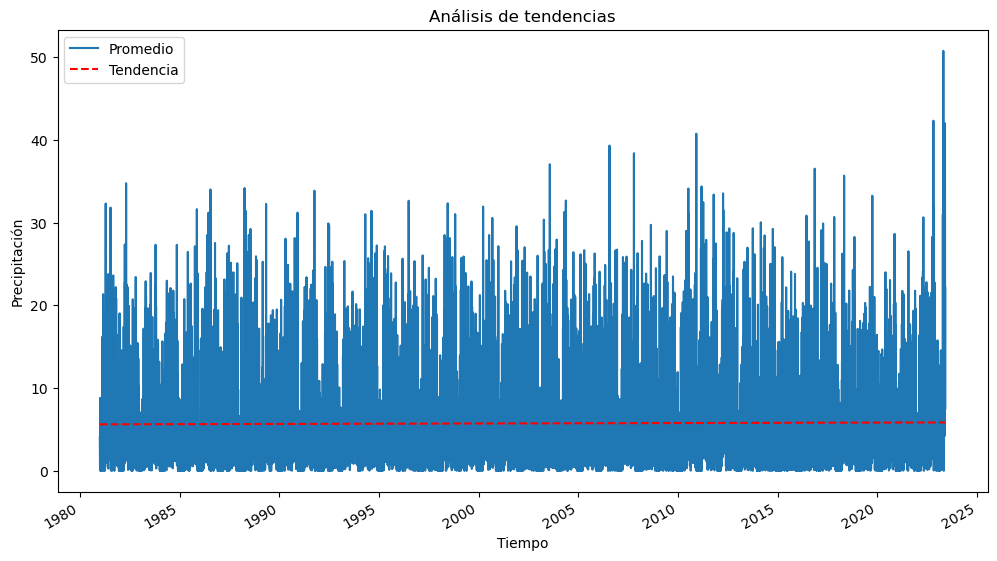

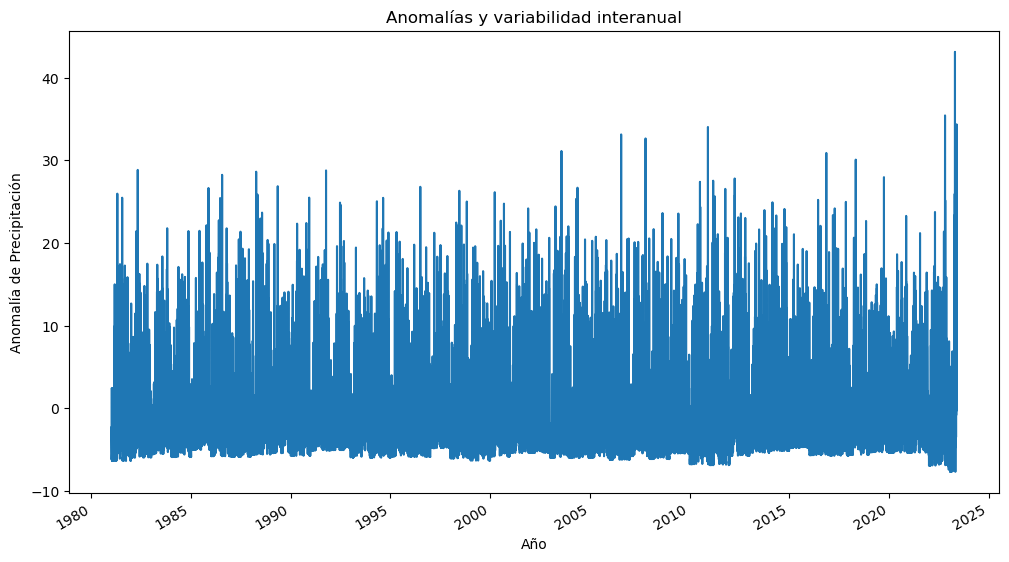

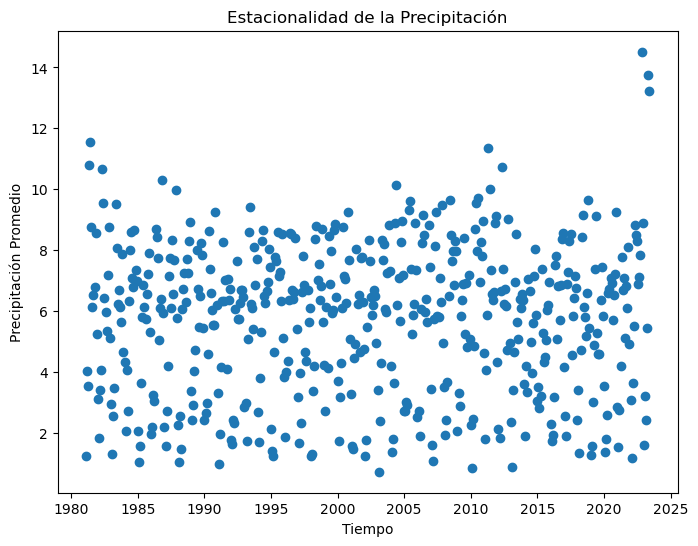

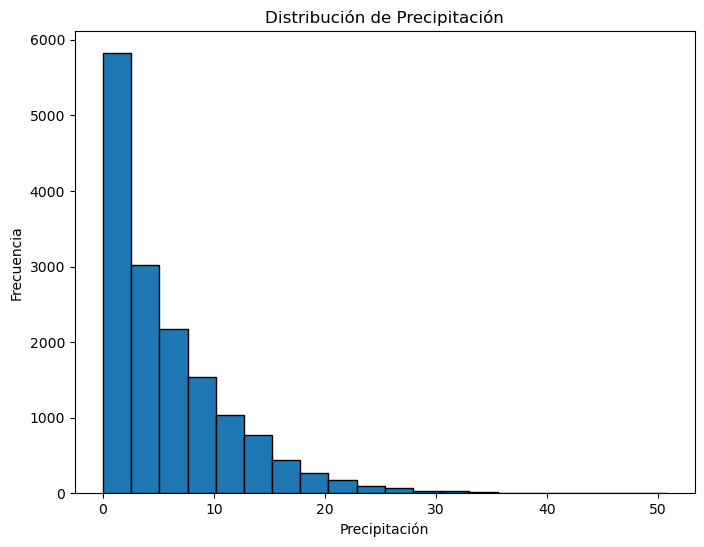

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Cargar el archivo .nc
data = xr.open_dataset('./data_Boyaca.nc')

# Convertir las fechas a tipo np.datetime64
data['time'] = data.time.astype('datetime64[ns]')

# Análisis de tendencias
trends = np.polyfit(data.time.values.astype(float), data.precip.mean(dim=('latitude', 'longitude')).values, deg=1)
trend_line = np.polyval(trends, data.time.values.astype(float))

# Anomalías y variabilidad interanual
annual_mean = data.precip.groupby('time.year').mean(dim='time')
anomalies = data.precip.groupby('time.year') - annual_mean
anomalies_mean = anomalies.mean(dim=('latitude', 'longitude'))

# Estacionalidad
monthly_mean = data.precip.groupby('time.month').mean(dim='time')
seasonal_mean = monthly_mean.mean(dim='month')

# Correlaciones espaciales
correlation = np.corrcoef(data.precip.mean(dim='time').values.reshape(-1), rowvar=False)

# Visualización de datos
plt.figure(figsize=(12, 6))
data.precip.mean(dim=('latitude', 'longitude')).plot(label='Promedio')
plt.plot(data.time, trend_line, 'r--', label='Tendencia')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Precipitación')
plt.title('Análisis de tendencias')

plt.figure(figsize=(12, 6))
anomalies_mean.plot()
plt.xlabel('Año')
plt.ylabel('Anomalía de Precipitación')
plt.title('Anomalías y variabilidad interanual')

# Calcular el promedio mensual
monthly_mean = data.precip.resample(time='1M').mean()

# Obtener los valores de tiempo y precipitación promedio mensual
time_values = monthly_mean.time.values
precipitation_values = monthly_mean.mean(dim=('latitude', 'longitude')).values

# Gráfico de dispersión con NumPy array
plt.figure(figsize=(8, 6))
plt.scatter(time_values, precipitation_values, marker='o') # type: ignore
plt.xlabel('Tiempo')
plt.ylabel('Precipitación Promedio')
plt.title('Estacionalidad de la Precipitación')

plt.show()

# Calcular el promedio de precipitación en todo el periodo
mean_precipitation = data.precip.mean(dim=('latitude', 'longitude'))

# Crear histograma de precipitación
plt.figure(figsize=(8, 6))
plt.hist(mean_precipitation, bins=20, edgecolor='black')
plt.xlabel('Precipitación')
plt.ylabel('Frecuencia')
plt.title('Distribución de Precipitación')
plt.show()




In [ ]:
import xarray as xr
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Paso 1: Cargar el archivo .nc
dataset = xr.open_dataset('archivo.nc')

# Paso 2: Preparar los datos
data = dataset['precip']
data_array = data.values
data_array = data_array.transpose(0, 2, 1)
data_mean = data_array.mean()
data_std = data_array.std()
data_array = (data_array - data_mean) / data_std

# Paso 3: Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(0.8 * data_array.shape[0])  # Tamaño del conjunto de entrenamiento (80%)
train_data = data_array[:train_size]  # Datos de entrenamiento
test_data = data_array[train_size:]  # Datos de prueba

# Paso 4: Construir el modelo de deep learning
model = Sequential()
model.add(LSTM(64, input_shape=(data_array.shape[1], data_array.shape[2])))  # Capa LSTM con 64 unidades
model.add(Dense(1))  # Capa densa con una unidad de salida
model.compile(loss='mean_squared_error', optimizer='adam')  # Compilar el modelo

# Paso 5: Entrenar el modelo
epochs = 10  # Número de épocas de entrenamiento
batch_size = 32  # Tamaño del lote (batch size)
model.fit(train_data, train_data[:, 1, 1], epochs=epochs, batch_size=batch_size)  # Entrenar el modelo

# Paso 6: Realizar predicciones
predictions = model.predict(test_data)  # Obtener las predicciones
predictions = (predictions * data_std) + data_mean  # Denormalizar las predicciones

print(predictions)  # Imprimir las predicciones


Epoch 1/10
388/388 [==============================] - 10s 21ms/step - loss: 0.3998
Epoch 2/10
388/388 [==============================] - 8s 22ms/step - loss: 0.2794
Epoch 3/10
388/388 [==============================] - 9s 24ms/step - loss: 0.3070
Epoch 4/10
388/388 [==============================] - 9s 24ms/step - loss: 0.2396
Epoch 5/10
388/388 [==============================] - 10s 25ms/step - loss: 0.1806
Epoch 6/10
388/388 [==============================] - 10s 26ms/step - loss: 0.1450
Epoch 7/10
388/388 [==============================] - 9s 24ms/step - loss: 0.1640
Epoch 8/10
388/388 [==============================] - 8s 21ms/step - loss: 0.1181
Epoch 9/10
388/388 [==============================] - 9s 23ms/step - loss: 0.2613
Epoch 10/10
97/97 [==============================] - 1s 10ms/step
[[ 1.4282551]
 [14.222946 ]
 [ 6.15108  ]
 ...
 [-1.2500677]
 [12.868787 ]
 [-1.9633589]]
